In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px
import random

from glob import glob
import cv2
from pathlib import Path
import os
from sklearn.metrics import classification_report

In [3]:
train_df = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train.csv')
train_annot = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train_annotations.csv')

In [4]:
from pathlib import Path

path = Path('/projects/sc73/ranzcr-clip-catheter-line-classification/train')

def add_path(row):

    row['image_path'] = str(path / (row['StudyInstanceUID'] + '.jpg'))
    return row

train_df = train_df.apply(add_path, axis=1)

In [5]:
# creates a function that displays one or more images
def display_image(paths):
  if type(paths) == str:
    image = cv2.imread(paths)
    plt.imshow(image)
    plt.figsize=(4,4)
    plt.show()

  elif type(paths) == pd.Series:
    paths = paths.tolist()

    image = []
    for path in paths:
      image.append(cv2.imread(path))

    fig, ax = plt.subplots(len(paths),1, figsize=(4,4))
    for i in range(len(paths)):
      ax[i].imshow(image[i])

    plt.tight_layout()
    plt.show()

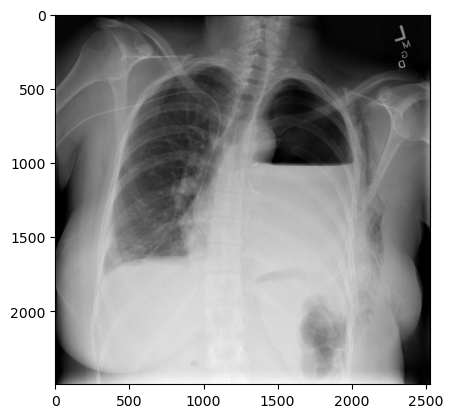

In [6]:
display_image(train_df['image_path'][2])

In [7]:
def save_overlay_annot(StudyInstanceUID):
  cmap = {'CVC - Normal':'mediumslateblue',
          'CVC - Borderline':'deeppink',
          'NGT - Normal':'greenyellow',
          'ETT - Normal':'lightseagreen',
          'CVC - Abnormal':'lawngreen',
          'ETT - Borderline':'orange',
          'Swan Ganz Catheter Present':'indianred',
          'NGT - Borderline':'yellow',
          'NGT - Abnormal':'deepskyblue',
          'ETT - Abnormal':'aquamarine',
          'NGT - Incompletely Imaged':'purple'}

  annot = train_annot[train_annot['StudyInstanceUID'] == StudyInstanceUID]
  image = cv2.imread(train_df[train_df['StudyInstanceUID'] == StudyInstanceUID]['image_path'].values[0])
  height, width, _ = image.shape
  dpi=100
  plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)

  labels_added = set()

  for i in range(len(annot)):
    points = np.array(ast.literal_eval(annot.iloc[i]['data']))
    x = points[:, 0]
    y = points[:, 1]
    label = annot.iloc[i]['label']

    plt.plot(x, y, color=cmap[annot.iloc[i]["label"]], linestyle='-')

  plt.imshow(image)
  plt.axis('off')
  plt.savefig(f'/fs03/sc73/Shekinah Robins/train_imgs2/{StudyInstanceUID}.jpg', bbox_inches='tight', pad_inches=0)
  plt.close()

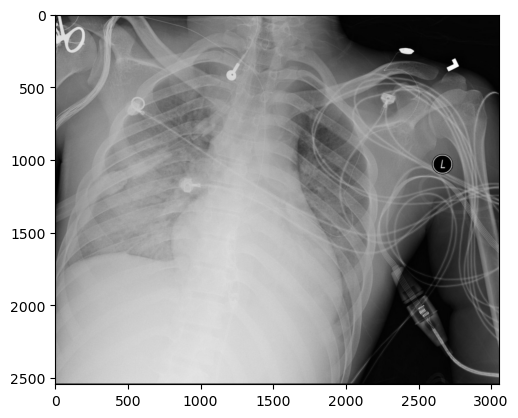

In [8]:
columns_to_check = [
    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
    'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged',
    'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline',
    'CVC - Normal', 'Swan Ganz Catheter Present'
]

train_df_all_zeros = train_df[train_df[columns_to_check].eq(0).all(axis=1)].reset_index(drop=True)

display_image(train_df_all_zeros['image_path'][2])

In [9]:
train_df = train_df[~train_df[columns_to_check].eq(0).all(axis=1)].reset_index(drop=True)

train_df = train_df[train_df['NGT - Incompletely Imaged'] == 0]
train_df = train_df.drop(columns=['NGT - Incompletely Imaged'])

train_df = train_df[train_df['Swan Ganz Catheter Present'] == 0]
train_df = train_df.drop(columns=['Swan Ganz Catheter Present'])
train_df.shape

(26752, 12)

## Modelling Pre-Processing

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from tensorflow.keras.applications.mobilenet import preprocess_input
from keras.regularizers import l2
from tensorflow.keras import layers

2024-10-16 15:39:59.478393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
tube_classifying = train_df.copy()

def cvc_exists(row):
    if row['CVC - Abnormal'] == 1 or row['CVC - Borderline'] == 1 or row['CVC - Normal'] == 1:
        return '1'
    else:
        return '0'

def ett_exists(row):
    if row['ETT - Abnormal'] == 1 or row['ETT - Borderline'] == 1 or row['ETT - Normal'] == 1:
        return '1'
    else:
        return '0'
        
def ngt_exists(row):
    if row['NGT - Abnormal'] == 1 or row['NGT - Borderline'] == 1 or row['NGT - Normal'] == 1:
        return '1'
    else:
        return '0'

tube_classifying['CVC'] = tube_classifying.apply(cvc_exists, axis=1)  
tube_classifying['ETT'] = tube_classifying.apply(ett_exists, axis=1)  
tube_classifying['NGT'] = tube_classifying.apply(ngt_exists, axis=1)

In [13]:
tube_classifying.head(2)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,PatientID,image_path,CVC,ETT,NGT
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,1,0,0,0,ec89415d1,/projects/sc73/ranzcr-clip-catheter-line-class...,0,0,1
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,1,0,3fc1c97e5,/projects/sc73/ranzcr-clip-catheter-line-class...,1,0,0


In [14]:
e = tube_classifying['ETT'].value_counts()

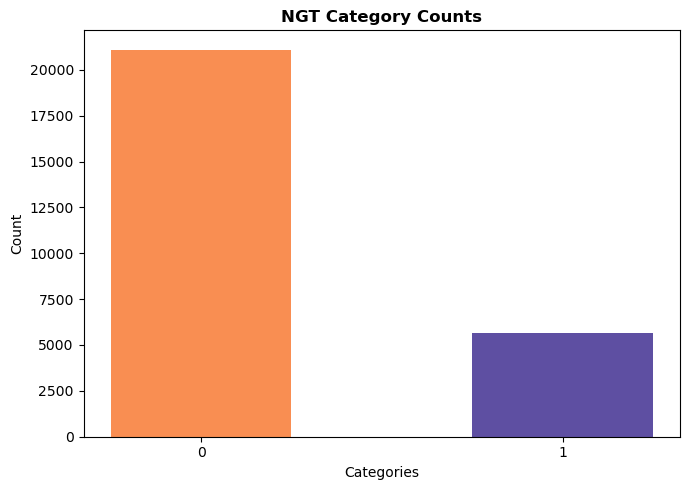

In [15]:
plt.figure(figsize=(7, 5))

# Generate colors
colors = plt.cm.Spectral(np.linspace(0.25, 1, len(e)))  

# Create the bar chart
plt.bar(e.index.astype(str), e.values, color=colors, width=0.5)  

# Set labels and title
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('NGT Category Counts', fontweight='bold')
plt.tight_layout()  
plt.show()

### Tube Classification Model

In [16]:
early_stopping_cb = EarlyStopping(patience=2, restore_best_weights=True, min_delta=0.0001, monitor = "val_accuracy")

def checkpoint_cb(filepath, monitor='val_accuracy', save_best_only=True, mode='max'):

    checkpoint_cb = ModelCheckpoint(
        filepath,
        monitor=monitor,
        save_best_only=save_best_only,
        mode=mode,
        verbose=1
    )
    return checkpoint_cb

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        layer.trainable = True
            
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
def build_model(base_model, num_classes=1):
    x = GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(1000, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = layers.Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### ETT Tubes

In [49]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(tube_classifying, test_size=0.2, random_state=42)

train_data['ETT'].value_counts()

ETT
0    16886
1     4515
Name: count, dtype: int64

In [50]:
ett_majority = train_data[train_data['ETT'] == '0'].sample(4515)
ett_minority = train_data[train_data['ETT'] == '1']

ett_ds = pd.concat([ett_minority, ett_majority])
ett_ds= ett_ds.sample(frac=1, random_state=40).reset_index(drop=True)
ett_ds['ETT'].value_counts()

ETT
0    4515
1    4515
Name: count, dtype: int64

In [51]:
datagen_ett = ImageDataGenerator(dtype='float32',
                                 preprocessing_function=preprocess_input, 
                                 validation_split=0.2,
                                 rotation_range=20,
                                 fill_mode='nearest'
                                )
test_datagen_ett = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)

train_generator_ett = datagen_ett.flow_from_dataframe(
    dataframe=ett_ds,
    x_col='image_path',       
    y_col='ETT',      
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',    
    subset='training',
    shuffle=True
)

val_generator_ett = datagen_ett.flow_from_dataframe(
    dataframe=ett_ds,
    x_col='image_path',         
    y_col='ETT',       
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',
    subset='validation', 
    shuffle = True
)

test_generator_ett = test_datagen_ett.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',         
    y_col='ETT',  
    target_size=(280,280),
    batch_size=32,
    class_mode='binary', 
    shuffle=False  
)

Found 7224 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.
Found 5351 validated image filenames belonging to 2 classes.


In [52]:
mobilenetV2_base_ett = MobileNetV2(weights='imagenet', include_top=False, input_shape=(280,280,3))

for layer in mobilenetV2_base_ett.layers:
  layer.trainable = False
    
mobilenetV2_ett = build_model(mobilenetV2_base_ett)

history_mobilenetV2_ett = mobilenetV2_ett.fit(
    train_generator_ett,
    validation_data=val_generator_ett,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('mobilenetV2_ett_us3.h5')]
)

Epoch 1/10
226/226 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7895
Epoch 1: val_accuracy improved from -inf to 0.83998, saving model to mobilenetV2_ett_us3.h5
226/226 [==============================] - 366s 2s/step - loss: 0.4921 - accuracy: 0.7895 - val_loss: 0.3734 - val_accuracy: 0.8400
Epoch 2/10
226/226 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8252
Epoch 2: val_accuracy improved from 0.83998 to 0.85271, saving model to mobilenetV2_ett_us3.h5
226/226 [==============================] - 280s 1s/step - loss: 0.3998 - accuracy: 0.8252 - val_loss: 0.3433 - val_accuracy: 0.8527
Epoch 3/10
226/226 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.8333
Epoch 3: val_accuracy improved from 0.85271 to 0.85991, saving model to mobilenetV2_ett_us3.h5
226/226 [==============================] - 277s 1s/step - loss: 0.3809 - accuracy: 0.8333 - val_loss: 0.3301 - val_accuracy: 0.8599
Epoch 4/10
226/226 [==============

In [53]:
unfreeze_model(mobilenetV2_ett)

history_mobilenetV2_ett_tuned = mobilenetV2_ett.fit(
    train_generator_ett,
    validation_data=val_generator_ett,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('mobilenetV2_ett_us3.h5')]
)

Epoch 1/10
226/226 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.8146
Epoch 1: val_accuracy improved from -inf to 0.85659, saving model to mobilenetV2_ett_us3.h5
226/226 [==============================] - 281s 1s/step - loss: 0.4125 - accuracy: 0.8146 - val_loss: 0.3592 - val_accuracy: 0.8566
Epoch 2/10
226/226 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8421
Epoch 2: val_accuracy did not improve from 0.85659
226/226 [==============================] - 286s 1s/step - loss: 0.3660 - accuracy: 0.8421 - val_loss: 0.3610 - val_accuracy: 0.8522
Epoch 3/10
226/226 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.8476
Epoch 3: val_accuracy did not improve from 0.85659
226/226 [==============================] - 295s 1s/step - loss: 0.3559 - accuracy: 0.8476 - val_loss: 0.3600 - val_accuracy: 0.8527


In [54]:
acc = history_mobilenetV2_ett.history['accuracy']
val_acc = history_mobilenetV2_ett.history['val_accuracy']

loss = history_mobilenetV2_ett.history['loss']
val_loss = history_mobilenetV2_ett.history['val_loss']

acc += history_mobilenetV2_ett_tuned.history['accuracy']
val_acc += history_mobilenetV2_ett_tuned.history['val_accuracy']

loss += history_mobilenetV2_ett_tuned.history['loss']
val_loss += history_mobilenetV2_ett_tuned.history['val_loss']

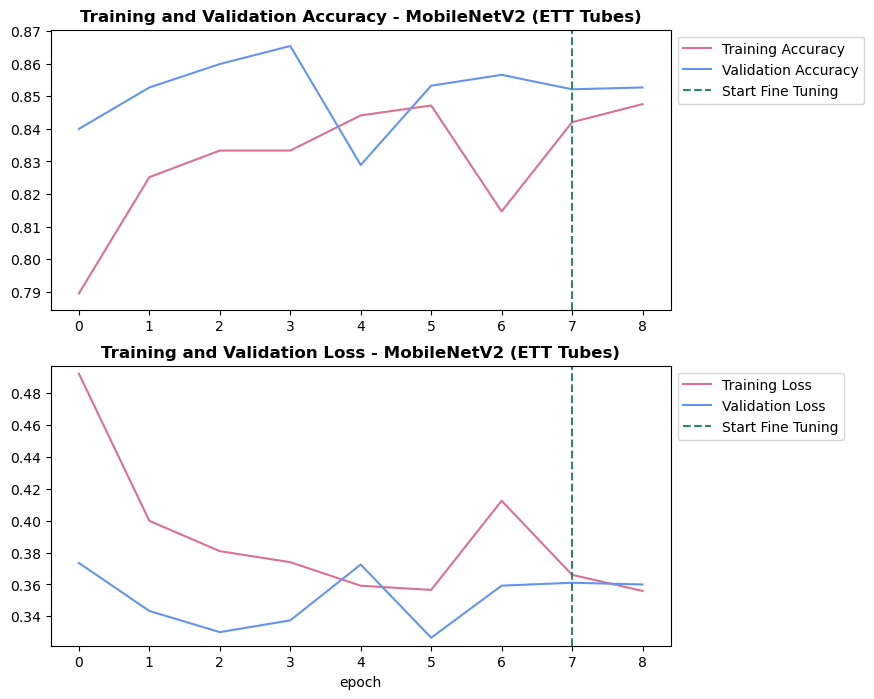

In [55]:
initial_epochs = len(history_mobilenetV2_ett.history['accuracy'])

acc_min = min(min(acc), min(val_acc)) - 0.005
acc_max = max(max(acc), max(val_acc)) + 0.005
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'palevioletred')
plt.plot(val_acc, label='Validation Accuracy', color='cornflowerblue')
plt.ylim([acc_min, acc_max])
plt.plot([8-1,8-1],
          plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Accuracy - MobileNetV2 (ETT Tubes)', fontweight = 'bold')

loss_min = min(min(loss), min(val_loss)) - 0.005
loss_max = max(max(loss), max(val_loss)) + 0.005
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color = 'palevioletred')
plt.plot(val_loss, label='Validation Loss', color='cornflowerblue' )
plt.ylim([loss_min, loss_max])
plt.plot([8-1,8-1],
         plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Loss - MobileNetV2 (ETT Tubes)', fontweight='bold')
plt.xlabel('epoch')

plt.savefig('acc_loss_mobilenetV2_ett.png', dpi=300, bbox_inches='tight')
plt.show()

168/168 [==============================] - 148s 880ms/step


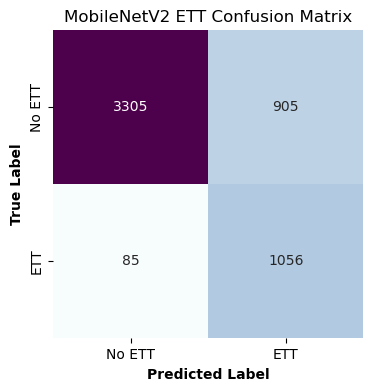

In [56]:
class_names = ['No ETT','ETT']
y_true_mobilenet = test_generator_ett.classes
y_pred_mobilenet = np.round(mobilenetV2_ett.predict(test_generator_ett))
cm = confusion_matrix(y_true_mobilenet, y_pred_mobilenet)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', cbar=False,
             xticklabels=class_names,  
             yticklabels=class_names)  
plt.title('MobileNetV2 ETT Confusion Matrix')
plt.xlabel('Predicted Label', fontweight = 'bold')
plt.ylabel('True Label', fontweight = 'bold')
plt.savefig('conf_matrix_mobilenetV2_us3.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
report = classification_report(y_true_mobilenet, y_pred_mobilenet, target_names=class_names)  
print(report)

              precision    recall  f1-score   support

      No ETT       0.97      0.79      0.87      4210
         ETT       0.54      0.93      0.68      1141

    accuracy                           0.81      5351
   macro avg       0.76      0.86      0.78      5351
weighted avg       0.88      0.81      0.83      5351



#### NGT Tubes

In [21]:
train_data['NGT'].value_counts()

NGT
0    17267
1     4134
Name: count, dtype: int64

In [22]:
ngt_majority = train_data[train_data['NGT'] == '0'].sample(4134)
ngt_minority = train_data[train_data['NGT'] == '1']

ngt_ds = pd.concat([ngt_minority, ngt_majority])
ngt_ds= ngt_ds.sample(frac=1, random_state=40).reset_index(drop=True)
ngt_ds['NGT'].value_counts()

NGT
0    4134
1    4134
Name: count, dtype: int64

In [23]:
datagen_ngt = ImageDataGenerator(dtype='float32',
                                 preprocessing_function=preprocess_input, 
                                 validation_split=0.2,
                                 rotation_range=20,
                                 fill_mode='nearest'
                                )
test_datagen_ngt = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)

train_generator_ngt = datagen_ngt.flow_from_dataframe(
    dataframe=ngt_ds,
    x_col='image_path',       
    y_col='NGT',      
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',    
    subset='training',
    shuffle=True
)

val_generator_ngt = datagen_ngt.flow_from_dataframe(
    dataframe=ngt_ds,
    x_col='image_path',         
    y_col='NGT',       
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',
    subset='validation', 
    shuffle = True
)

test_generator_ngt = test_datagen_ngt.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',         
    y_col='NGT',  
    target_size=(280,280),
    batch_size=32,
    class_mode='binary', 
    shuffle=False  
)

Found 6615 validated image filenames belonging to 2 classes.
Found 1653 validated image filenames belonging to 2 classes.
Found 5351 validated image filenames belonging to 2 classes.


In [24]:
mobilenetV2_base_ngt = MobileNetV2(weights='imagenet', include_top=False, input_shape=(280,280,3))

for layer in mobilenetV2_base_ngt.layers:
  layer.trainable = False
    
mobilenetV2_ngt = build_model(mobilenetV2_base_ngt)

history_mobilenetV2_ngt = mobilenetV2_ngt.fit(
    train_generator_ngt,
    validation_data=val_generator_ngt,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('mobilenetV2_ngt.h5')]
)

2024-10-16 15:43:46.958511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 15:43:47.091606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7000 MB memory:  -> device: 0, name: Tesla P4, pci bus id: 0000:af:00.0, compute capability: 6.1


Epoch 1/10


2024-10-16 15:43:54.019472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-10-16 15:43:54.464348: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


207/207 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.7826
Epoch 1: val_accuracy improved from -inf to 0.81549, saving model to mobilenetV2_ngt.h5
207/207 [==============================] - 401s 2s/step - loss: 0.4999 - accuracy: 0.7826 - val_loss: 0.4173 - val_accuracy: 0.8155
Epoch 2/10
207/207 [==============================] - ETA: 0s - loss: 0.4271 - accuracy: 0.8135
Epoch 2: val_accuracy improved from 0.81549 to 0.81609, saving model to mobilenetV2_ngt.h5
207/207 [==============================] - 258s 1s/step - loss: 0.4271 - accuracy: 0.8135 - val_loss: 0.4260 - val_accuracy: 0.8161
Epoch 3/10
207/207 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.8221
Epoch 3: val_accuracy did not improve from 0.81609
207/207 [==============================] - 253s 1s/step - loss: 0.4130 - accuracy: 0.8221 - val_loss: 0.4184 - val_accuracy: 0.8113
Epoch 4/10
207/207 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8243
E

In [25]:
unfreeze_model(mobilenetV2_ngt)

history_mobilenetV2_ngt_tuned = mobilenetV2_ngt.fit(
    train_generator_ngt,
    validation_data=val_generator_ngt,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('mobilenetV2_ngt.h5')]
)

Epoch 1/10
207/207 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.7979
Epoch 1: val_accuracy improved from -inf to 0.79734, saving model to mobilenetV2_ngt.h5
207/207 [==============================] - 258s 1s/step - loss: 0.4491 - accuracy: 0.7979 - val_loss: 0.4954 - val_accuracy: 0.7973
Epoch 2/10
207/207 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.8213
Epoch 2: val_accuracy did not improve from 0.79734
207/207 [==============================] - 255s 1s/step - loss: 0.4117 - accuracy: 0.8213 - val_loss: 0.5108 - val_accuracy: 0.7967
Epoch 3/10
207/207 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8349
Epoch 3: val_accuracy improved from 0.79734 to 0.80702, saving model to mobilenetV2_ngt.h5
207/207 [==============================] - 260s 1s/step - loss: 0.3900 - accuracy: 0.8349 - val_loss: 0.5050 - val_accuracy: 0.8070
Epoch 4/10
207/207 [==============================] - ETA: 0s - loss: 0.3722 - accurac

In [41]:
acc = history_mobilenetV2_ngt.history['accuracy']
val_acc = history_mobilenetV2_ngt.history['val_accuracy']

loss = history_mobilenetV2_ngt.history['loss']
val_loss = history_mobilenetV2_ngt.history['val_loss']

acc += history_mobilenetV2_ngt_tuned.history['accuracy']
val_acc += history_mobilenetV2_ngt_tuned.history['val_accuracy']

loss += history_mobilenetV2_ngt_tuned.history['loss']
val_loss += history_mobilenetV2_ngt_tuned.history['val_loss']

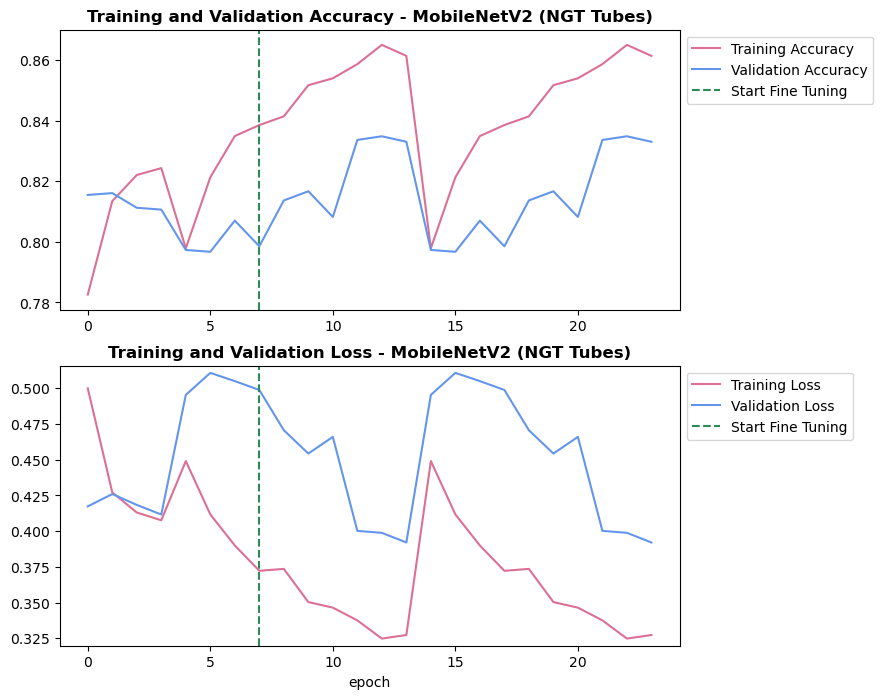

In [42]:
initial_epochs = len(history_mobilenetV2_ngt.history['accuracy'])

acc_min = min(min(acc), min(val_acc)) - 0.005
acc_max = max(max(acc), max(val_acc)) + 0.005
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'palevioletred')
plt.plot(val_acc, label='Validation Accuracy', color='cornflowerblue')
plt.ylim([acc_min, acc_max])
plt.plot([8-1,8-1],
          plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Accuracy - MobileNetV2 (NGT Tubes)', fontweight = 'bold')

loss_min = min(min(loss), min(val_loss)) - 0.005
loss_max = max(max(loss), max(val_loss)) + 0.005
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color = 'palevioletred')
plt.plot(val_loss, label='Validation Loss', color='cornflowerblue' )
plt.ylim([loss_min, loss_max])
plt.plot([8-1,8-1],
         plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Loss - MobileNetV2 (NGT Tubes)', fontweight='bold')
plt.xlabel('epoch')

plt.savefig('acc_loss_mobilenetV2_ngt.png', dpi=300, bbox_inches='tight')
plt.show()

168/168 [==============================] - 112s 665ms/step


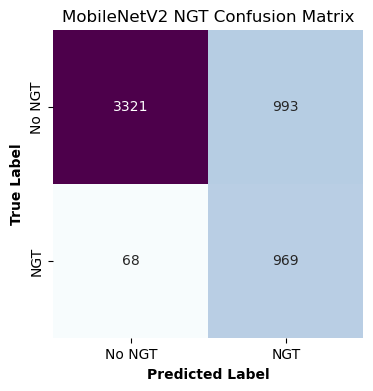

In [43]:
class_names = ['No NGT','NGT']
y_true_mobilenetV2ngt = test_generator_ngt.classes
y_pred_mobilenetV2ngt = np.round(mobilenetV2_ngt.predict(test_generator_ngt))
cm = confusion_matrix(y_true_mobilenetV2ngt, y_pred_mobilenetV2ngt)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', cbar=False,
             xticklabels=class_names,  
             yticklabels=class_names)  
plt.title('MobileNetV2 NGT Confusion Matrix')
plt.xlabel('Predicted Label', fontweight = 'bold')
plt.ylabel('True Label', fontweight = 'bold')
plt.savefig('conf_matrix_mobilenetV2ngt_us3.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
report = classification_report(y_true_mobilenetV2ngt, y_pred_mobilenetV2ngt, target_names=class_names)  
print(report)

              precision    recall  f1-score   support

      No NGT       0.98      0.77      0.86      4314
         NGT       0.49      0.93      0.65      1037

    accuracy                           0.80      5351
   macro avg       0.74      0.85      0.75      5351
weighted avg       0.89      0.80      0.82      5351



#### CVC Tubes

In [30]:
train_data['CVC'].value_counts()

CVC
1    20941
0      460
Name: count, dtype: int64

In [31]:
cvc_majority = train_data[train_data['CVC'] == '1'].sample(2000)
cvc_minority = train_data[train_data['CVC'] == '0']

cvc_minority_up = resample(cvc_minority, replace=True, n_samples=(len(cvc_majority) - len(cvc_minority)), random_state=42)

cvc_ds = pd.concat([cvc_minority, cvc_majority])
cvc_ds = pd.concat([cvc_ds, cvc_minority_up])
cvc_ds= cvc_ds.sample(frac=1, random_state=40).reset_index(drop=True)
cvc_ds['CVC'].value_counts()

CVC
0    2000
1    2000
Name: count, dtype: int64

In [32]:
datagen_cvc = ImageDataGenerator(dtype='float32',
                                 preprocessing_function=preprocess_input, 
                                 validation_split=0.2,
                                 rotation_range=20,
                                 fill_mode='nearest'
                                )
test_datagen_cvc = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)

train_generator_cvc = datagen_cvc.flow_from_dataframe(
    dataframe=cvc_ds,
    x_col='image_path',       
    y_col='CVC',      
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',    
    subset='training',
    shuffle=True
)

val_generator_cvc = datagen_cvc.flow_from_dataframe(
    dataframe=cvc_ds,
    x_col='image_path',         
    y_col='CVC',       
    target_size=(280,280),
    batch_size=32,
    class_mode='binary',
    subset='validation', 
    shuffle = True
)

test_generator_cvc = test_datagen_cvc.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',         
    y_col='CVC',  
    target_size=(280,280),
    batch_size=32,
    class_mode='binary', 
    shuffle=False  
)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 5351 validated image filenames belonging to 2 classes.


In [33]:
mobilenetV2_base_cvc = MobileNetV2(weights='imagenet', include_top=False, input_shape=(280,280,3))

for layer in mobilenetV2_base_cvc.layers:
  layer.trainable = False
    
mobilenetV2_cvc = build_model(mobilenetV2_base_cvc)

history_mobilenetV2_cvc = mobilenetV2_cvc.fit(
    train_generator_cvc,
    validation_data=val_generator_cvc,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('mobilenetV2_cvc.h5')]
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.6750
Epoch 1: val_accuracy improved from -inf to 0.74000, saving model to mobilenetV2_cvc.h5
100/100 [==============================] - 153s 2s/step - loss: 0.6510 - accuracy: 0.6750 - val_loss: 0.5152 - val_accuracy: 0.7400
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.7244
Epoch 2: val_accuracy improved from 0.74000 to 0.80250, saving model to mobilenetV2_cvc.h5
100/100 [==============================] - 124s 1s/step - loss: 0.5390 - accuracy: 0.7244 - val_loss: 0.4687 - val_accuracy: 0.8025
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.7538
Epoch 3: val_accuracy did not improve from 0.80250
100/100 [==============================] - 123s 1s/step - loss: 0.5128 - accuracy: 0.7538 - val_loss: 0.4359 - val_accuracy: 0.8025
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.5004 - accurac

In [34]:
unfreeze_model(mobilenetV2_cvc)

history_mobilenetV2_cvc_tuned = mobilenetV2_cvc.fit(
    train_generator_cvc,
    validation_data=val_generator_cvc,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb('mobilenetV2_cvc.h5')]
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.5644 - accuracy: 0.7059
Epoch 1: val_accuracy improved from -inf to 0.78625, saving model to mobilenetV2_cvc.h5
100/100 [==============================] - 128s 1s/step - loss: 0.5644 - accuracy: 0.7059 - val_loss: 0.4631 - val_accuracy: 0.7862
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.7513
Epoch 2: val_accuracy did not improve from 0.78625
100/100 [==============================] - 124s 1s/step - loss: 0.5172 - accuracy: 0.7513 - val_loss: 0.4689 - val_accuracy: 0.7850
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.7588
Epoch 3: val_accuracy improved from 0.78625 to 0.78750, saving model to mobilenetV2_cvc.h5
100/100 [==============================] - 124s 1s/step - loss: 0.4933 - accuracy: 0.7588 - val_loss: 0.4583 - val_accuracy: 0.7875
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.4744 - accurac

In [45]:
acc = history_mobilenetV2_cvc.history['accuracy']
val_acc = history_mobilenetV2_cvc.history['val_accuracy']

loss = history_mobilenetV2_cvc.history['loss']
val_loss = history_mobilenetV2_cvc.history['val_loss']

acc += history_mobilenetV2_cvc_tuned.history['accuracy']
val_acc += history_mobilenetV2_cvc_tuned.history['val_accuracy']

loss += history_mobilenetV2_cvc_tuned.history['loss']
val_loss += history_mobilenetV2_cvc_tuned.history['val_loss']

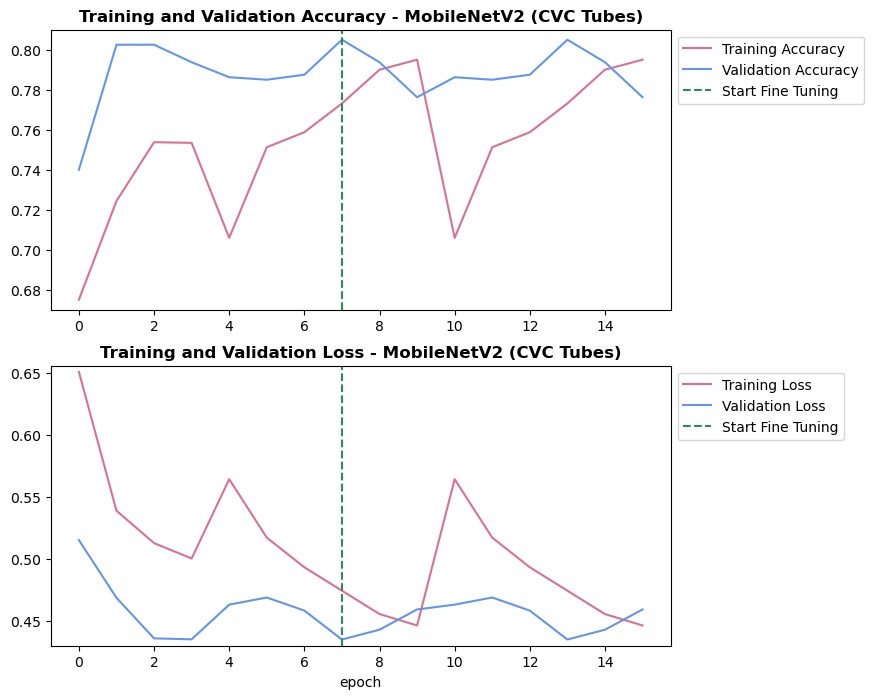

In [46]:
initial_epochs = len(history_mobilenetV2_cvc.history['accuracy'])

acc_min = min(min(acc), min(val_acc)) - 0.005
acc_max = max(max(acc), max(val_acc)) + 0.005
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'palevioletred')
plt.plot(val_acc, label='Validation Accuracy', color='cornflowerblue')
plt.ylim([acc_min, acc_max])
plt.plot([8-1,8-1],
          plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Accuracy - MobileNetV2 (CVC Tubes)', fontweight = 'bold')

loss_min = min(min(loss), min(val_loss)) - 0.005
loss_max = max(max(loss), max(val_loss)) + 0.005
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color = 'palevioletred')
plt.plot(val_loss, label='Validation Loss', color='cornflowerblue' )
plt.ylim([loss_min, loss_max])
plt.plot([8-1,8-1],
         plt.ylim(), label='Start Fine Tuning', color='seagreen', linestyle='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Training and Validation Loss - MobileNetV2 (CVC Tubes)', fontweight='bold')
plt.xlabel('epoch')

plt.savefig('acc_loss_mobilenetV2_cvc.png', dpi=300, bbox_inches='tight')
plt.show()

168/168 [==============================] - 108s 642ms/step


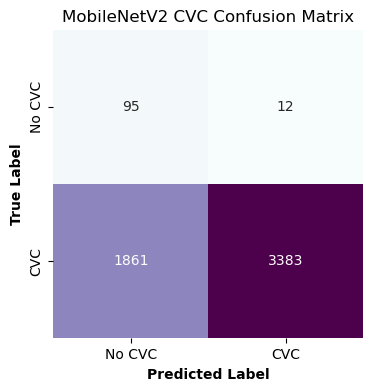

In [47]:
class_names = ['No CVC','CVC']
y_true_mobilenetV2cvc = test_generator_cvc.classes
y_pred_mobilenetV2cvc = np.round(mobilenetV2_cvc.predict(test_generator_cvc))
cm = confusion_matrix(y_true_mobilenetV2cvc, y_pred_mobilenetV2cvc)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', cbar=False,
             xticklabels=class_names,  
             yticklabels=class_names)  
plt.title('MobileNetV2 CVC Confusion Matrix')
plt.xlabel('Predicted Label', fontweight = 'bold')
plt.ylabel('True Label', fontweight = 'bold')
plt.savefig('conf_matrix_mobilenetV2cvc_us3.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
report = classification_report(y_true_mobilenetV2cvc, y_pred_mobilenetV2cvc, target_names=class_names)  
print(report)

              precision    recall  f1-score   support

      No CVC       0.05      0.89      0.09       107
         CVC       1.00      0.65      0.78      5244

    accuracy                           0.65      5351
   macro avg       0.52      0.77      0.44      5351
weighted avg       0.98      0.65      0.77      5351

